In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps #type: ignore

In [2]:
model = 'alt-llama-3'
sv = False
dpi = 500
transparent = False
task = 'alpaca'
layers = 8
alora_layers = 32
blora_layers = 35

methods = {
    'lora': {'lr': 2e-5, 'bs': 1, 'layers': 0, 'color': 'blue', 'label': 'lora', 'marker': 'o', 'linestyle': '-'},
    # 'alora': {'lr': 2e-5, 'bs': 2, 'layers': alora_layers, 'color': 'green', 'label': 'alora', 'marker': 's', 'linestyle': '-'},
    # 'blora': {'lr': 2e-5, 'bs': 2, 'layers': blora_layers, 'color': 'green', 'label': 'blora', 'marker': 's', 'linestyle': '-'},
    # 'adora': {'lr': 2e-5, 'bs': 2, 'layers': alora_layers, 'color': 'green', 'label': 'adora', 'marker': 's', 'linestyle': '-'},
    'alpha': {'lr': 2e-6, 'bs': 1, 'layers': layers, 'color': 'red', 'label': 'alpha', 'marker': '^', 'linestyle': '-'},
    'layer': {'lr': 2e-6, 'bs': 1, 'layers': layers, 'color': 'blue', 'label': 'layer', 'marker': '^', 'linestyle': '-'},
    # 'random': {'lr': 2e-6, 'bs': 1, 'layers': layers, 'color': 'green', 'label': 'random', 'marker': '^', 'linestyle': '-'},
    # 'full': {'lr': 2e-7, 'bs': 2, 'layers': 250, 'color': 'purple', 'label': 'full', 'marker': 'x', 'linestyle': '-'},
    # 'dora': {'lr': 2e-5, 'bs': 4, 'layers': 0, 'color': 'orange', 'label': 'dora', 'marker': 'd', 'linestyle': '-'},
}
seed_list = [7, 42, 53, 76, 89, 357, 666, 1337]
paths = {}

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)


lr = 2e-6
bs = 1
layers = 8
label = 'random'
for sd in seed_list:
    methods[f'{label}_{sd}'] = {'lr': lr, 'bs': bs, 'layers': layers, 'color': 'green', 'label': label, 'marker': 's', 'linestyle': '-'}
    paths[f'{label}_{sd}'] = f'./output/{model}/seed_{sd}/{task}/lr_{lr}/batch_{bs}/{label}/layers_{layers}'

for k,v in methods.items():
    if 'lora' in k:
        paths[k] = f'./output/llama-3/{task}/lr_{methods[k]["lr"]}/batch_{methods[k]["bs"]}/{methods[k]["label"]}/layers_{methods[k]["layers"]}'
    elif 'random' not in k:
        paths[k] = f'./output/{model}/seed_7/{task}/lr_{methods[k]["lr"]}/batch_{methods[k]["bs"]}/{methods[k]["label"]}/layers_{methods[k]["layers"]}'

dictionary = {}
for k,v in paths.items():
    dictionary[k] = {'train_loss': [], 'time': []}

In [3]:
for key in dictionary.keys():
    path = paths[key]
    path = os.path.join(path, "finetune.npy")
    baseline = np.load(path, allow_pickle=True).item()
    for key2 in dictionary[key].keys():
        dictionary[key][key2].append(baseline[key2])
        dictionary[key][key2] = np.array(dictionary[key][key2]) # type: ignore

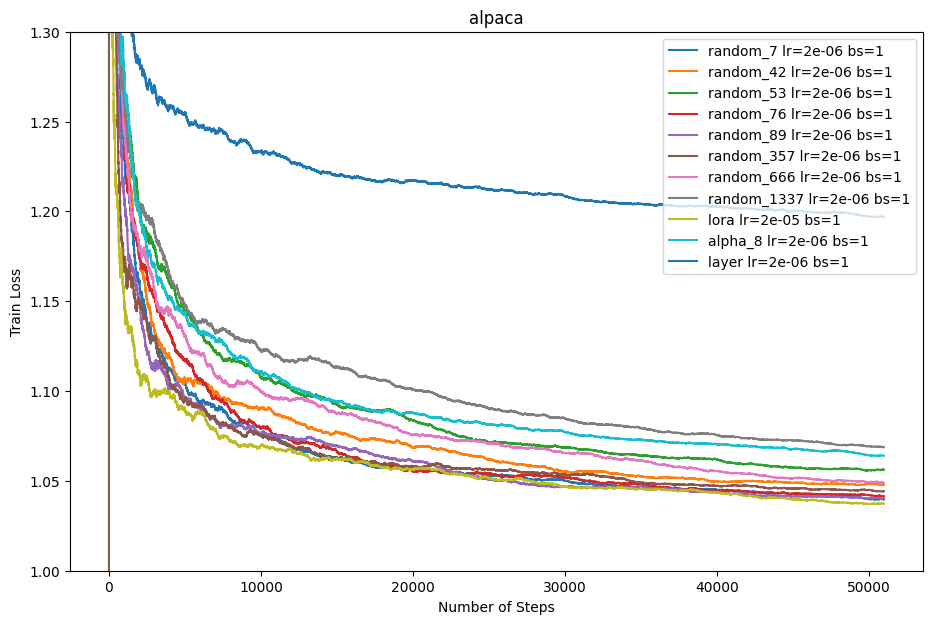

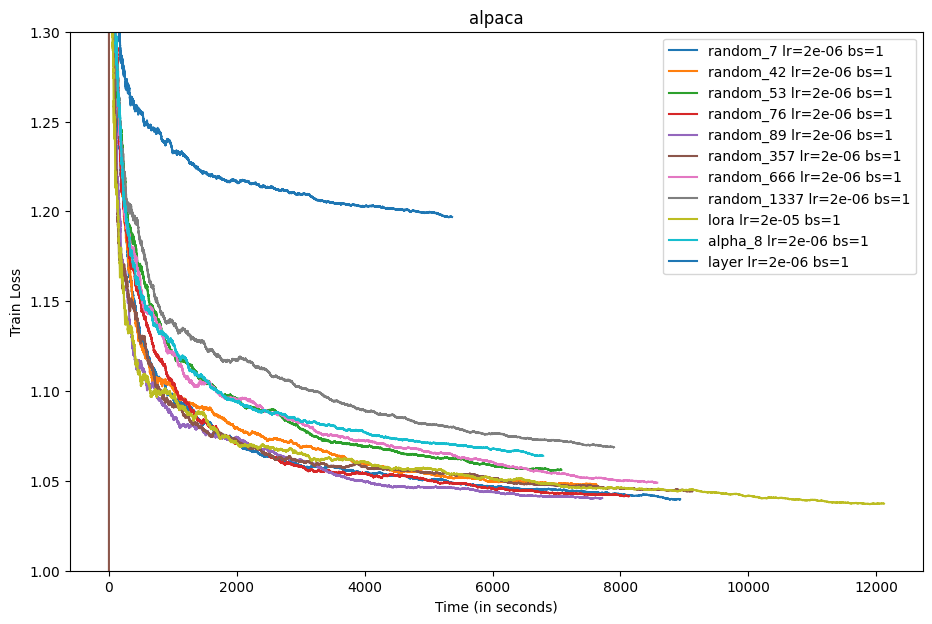

In [4]:
plt.figure(figsize=(11, 7))
for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key or 'blora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    plt.plot(dictionary[key]['train_loss'][0], label=tag)
    plt.xlabel("Number of Steps")
    plt.ylabel("Train Loss")
plt.ylim(1, 1.3)
plt.legend()
plt.title(f"{task}")
plt.show()

plt.figure(figsize=(11, 7))
for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key or 'blora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    plt.plot(dictionary[key]['time'][0],dictionary[key]['train_loss'][0], label=tag)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Train Loss")
plt.ylim(1, 1.3)
plt.legend()
plt.title(f"{task}")
plt.show()

# exit()

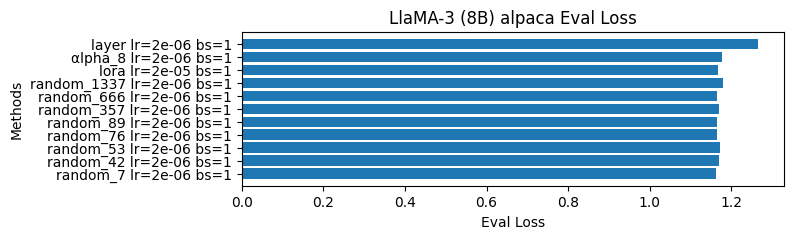

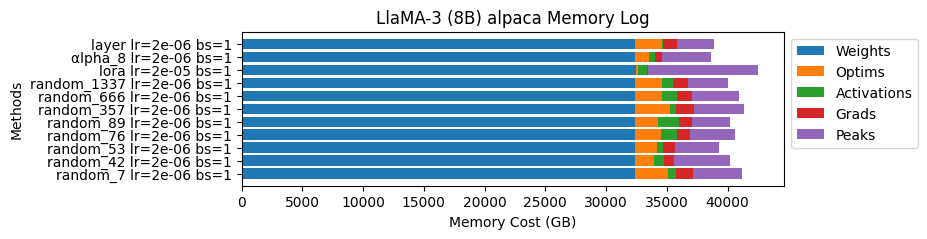

In [5]:
mem_dict = {
    'categories': [],
    'weights': [],
    'optims': [],
    'activations': [],
    'grads': [],
    'peaks': [],
}

eval_loss = {}
for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key:
        tag = 'α' + key[1:] + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    elif 'blora' in key:
        tag = 'β' + key[1:] + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    mem_dict['categories'].append(tag)
    path = paths[key]
    path = os.path.join(path, "stats.json")
    with open(path, 'r') as f:
        data = json.load(f)
    stats = pd.DataFrame([data])
    mem_dict['weights'].append(stats['weight_mem'].mean())
    mem_dict['optims'].append(stats['optimizer_mem'].mean())
    mem_dict['activations'].append(stats['activation_mem'].mean())
    mem_dict['grads'].append(stats['grad_mem'].mean())
    mem_dict['peaks'].append(stats['peak_mem'].mean())
    eval_loss[key] = stats['eval_loss'].mean()

for key in mem_dict.keys():
    mem_dict[key] = np.array(mem_dict[key]) # type: ignore
mem_dict['peaks'] = mem_dict['peaks'] - (mem_dict['weights'] + mem_dict['optims'] + mem_dict['activations'] + mem_dict['grads']) # type: ignore

# Plot eval_loss for each
plt.figure(figsize=(7, 2))
plt.barh(mem_dict['categories'], [eval_loss[k] for k in dictionary.keys()])
plt.xlabel('Eval Loss')
plt.ylabel('Methods')
plt.title(f'LlaMA-3 (8B) {task} Eval Loss')
plt.show()

# Plot memory cost for each
plt.figure(figsize=(7, 2))
left = [0] * len(mem_dict['categories'])
for key in mem_dict.keys():
    if key == 'categories':
        continue
    plt.barh(mem_dict['categories'][:], mem_dict[key][:], left=left[:], label=key[0].upper()+key[1:])
    left += mem_dict[key]
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title(f'LlaMA-3 (8B) {task} Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()
# exit(0)

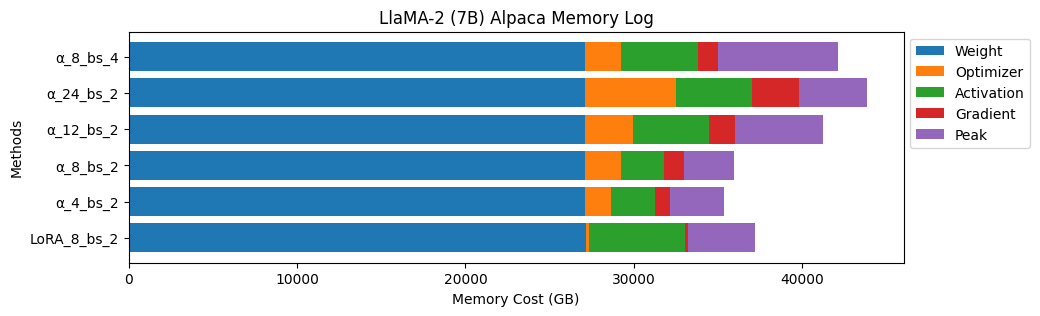

In [6]:
# Alpaca_Data
plt.figure(figsize=(10, 3))
categories = ['LoRA_8_bs_2', 'α_4_bs_2', 'α_8_bs_2', 'α_12_bs_2', 'α_24_bs_2', 'α_8_bs_4']
Weight = [27167.883264, 27087.929344, 27087.929344, 27087.929344, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 1585.47968, 2122.350592, 2885.71392, 5402.29632, 2122.350592]
Activation = [5737.52832, 2575.353344, 2604.649472, 4503.892992, 4546.884608, 4574.863872]
Gradient =   [157.92384, 875.31776, 1143.753216, 1525.43488, 2784.250368, 1193.931264]
Peak = [37186.260992, 35369.175552, 35976.432128, 41205.979136, 43821.993984, 42142.918144]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')
plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)
plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)
plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)
plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) Alpaca Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'Alpaca_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()


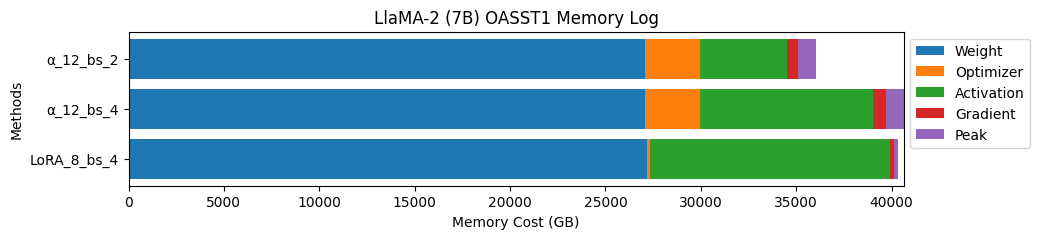

In [7]:
# Alpaca_Data
plt.figure(figsize=(10, 2))
categories = ['LoRA_8_bs_4', 'α_12_bs_4', 'α_12_bs_2']
Weight = [27167.883264, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 2885.71392, 2885.71392]
Activation = [12593.586688, 9063.457792, 4550.16448]
Gradient =   [229.114368, 1592.017408, 1525.691392]
Peak = [40351.6416, 39729.840128, 35118.135808]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')
plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)
plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)
plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)
plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) OASST1 Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'OASST1_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()


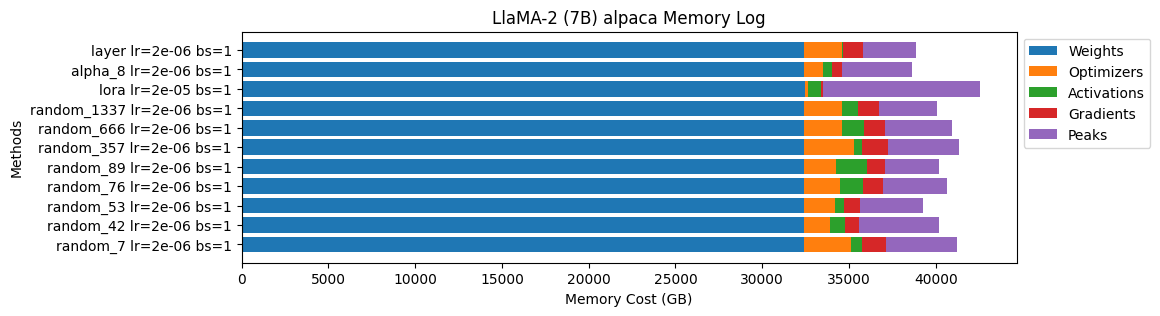

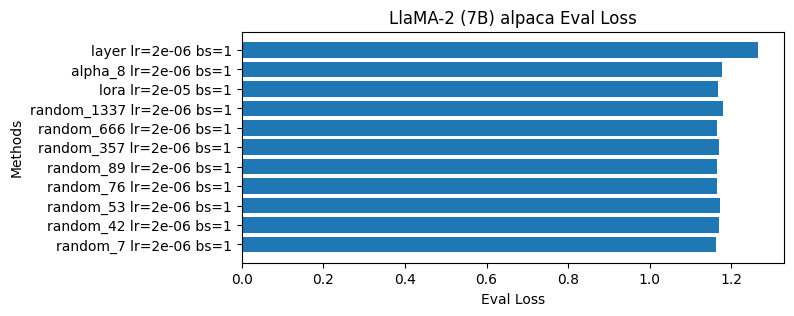

In [8]:
categories = []
weights = []
optims = []
activations = []
grads = []
peaks = []
eval_loss = {}

for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    categories.append(tag)
    path = paths[key]
    path = os.path.join(path, "stats.json")
    with open(path, 'r') as f:
        data = json.load(f)
    stats = pd.DataFrame([data])
    weights.append(stats['weight_mem'].mean())
    optims.append(stats['optimizer_mem'].mean())
    activations.append(stats['activation_mem'].mean())
    grads.append(stats['grad_mem'].mean())
    peaks.append(stats['peak_mem'].mean())
    eval_loss[key] = stats['eval_loss'].mean()

categories = np.array(categories)
weights = np.array(weights)
optims = np.array(optims)
activations = np.array(activations)
grads = np.array(grads)
peaks = np.array(peaks)
eval_loss = np.array([eval_loss[k] for k in dictionary.keys()])
peaks = peaks - (weights + optims + activations + grads) # type: ignore

plt.figure(figsize=(10, 3))
plt.barh(categories, weights, label='Weights')
plt.barh(categories, optims, left=weights, label='Optimizers')
plt.barh(categories, activations, left=weights + optims, label='Activations')
plt.barh(categories, grads, left=weights + optims + activations, label='Gradients')
plt.barh(categories, peaks, left=weights + optims + activations + grads, label='Peaks')
# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title(f'LlaMA-2 (7B) {task} Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Plot eval_loss for each
plt.figure(figsize=(7, 3))
plt.barh(categories, eval_loss)
plt.xlabel('Eval Loss')
plt.ylabel('Methods')
plt.title(f'LlaMA-2 (7B) {task} Eval Loss')
plt.show()